### auto clustering of k-means

In [677]:
def port_5km(data, lat, lon):
    '''
    port 좌표와 data lon, lat를 이용하여 거리계산
    '''
    data1 = data.groupby(['MMSI']).last()
    L1 = []
    
    for i,j,k in zip(data1.index, data1['LAT'], data1['LON']):
        R = 6373.0 
        lat1 = radians(j) 
        lon1 = radians(k) 
        lat2 = radians(lat) 
        lon2 = radians(lon)
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
        distance = R * c
        L1.append(distance)

    df1 = pd.DataFrame(list(zip(data1.index, L1)), columns = ['MMSI', 'distance'])
    df2 = df1[df1['distance'] <= 5]['MMSI'].tolist()
    df3 = data[data['MMSI'].isin(df2)].reset_index(drop=True)
    
    return df3

In [864]:
def representative_value(data):
    '''
    representative value 추출 / 출발점, 도착점, 9개의 대푯값 추출
    y_value가 있으면, else문 : y_value도 같이 추출한다.
    '''
    if 'y_value' not in data.columns:
        L1 = list()
        for i, j in data.groupby('MMSI').agg({'MMSI': 'unique', 'SPEED': 'count'}).reset_index(drop=True).apply(lambda x: (x['MMSI'][0], x['SPEED']), axis=1).tolist():
            for k in range(0, 11):
                k = k/10
                df1 = data[data['MMSI'] == i][['MMSI', 'LAT', 'LON']].reset_index()

                if k == 0:
                    L2 = list()
                    L2.extend(list(df1[['MMSI', 'LAT', 'LON']].iloc[0, :]))
                    
                elif 0 < k < 1:
                    L2.extend(list(df1[['LAT', 'LON']].iloc[int(round(j*k)), :]))

                else:
                    L2.extend(list(df1[['LAT', 'LON']].iloc[-1, :]))
                    
            L1.append(L2)

        df = pd.DataFrame(L1)
        
        a = [['MMSI', 'Start_LAT', 'Start_LON'], chain.from_iterable([['rpst_value_LAT'+str(i), 'rpst_value_LON'+str(i)] for i in range(1,10)]), ['End_LAT', 'End_LON']]
        a = list(chain.from_iterable(a))
        
        df.columns = a
        
        
        # LAT weighted *2
        df[df.columns[['LAT' in i for i in df.columns]]] = df[df.columns[['LAT' in i for i in df.columns]]]*2
        df.iloc[:, 1:7] = df.iloc[:, 1:7]*3
        
        return df

    else:
        L1 = list()
        for i, j in data.groupby('MMSI').agg({'MMSI': 'unique', 'SPEED': 'count'}).reset_index(drop=True).apply(lambda x: (x['MMSI'][0], x['SPEED']), axis=1).tolist():
            for k in range(0, 11, 1):
                k = k/10
                df1 = data[data['MMSI'] == i][['MMSI', 'LAT', 'LON', 'y_value']].reset_index()

                if k == 0:
                    L2 = list()
                    L2.extend(list(df1[['MMSI', 'LAT', 'LON', 'y_value']].iloc[0, :]))
                elif 0 < k < 1:
                    L2.extend(list(df1[['LAT', 'LON', 'y_value']].iloc[int(round(j*k)), :]))
                else:
                    L2.extend(list(df1[['LAT', 'LON']].iloc[-1, :]))
            L1.append(L2)

        df = pd.DataFrame(L1)

#         df.columns = ['MMSI', 'Start_LAT', 'Start_LON', 'rpst_value_LAT1', 'rpst_value_LON1', 'rpst_value_LAT2', 'rpst_value_LON2',
#                      'rpst_value_LAT3', 'rpst_value_LON3', 'rpst_value_LAT4', 'rpst_value_LON4', 'rpst_value_LAT5', 'rpst_value_LON5',
#                      'rpst_value_LAT6', 'rpst_value_LON6', 'rpst_value_LAT7', 'rpst_value_LON7', 'rpst_value_LAT8', 'rpst_value_LON8',
#                      'rpst_value_LA9', 'rpst_value_LON9', 'End_LAT', 'End_LON']
    
    
    
        return df

In [865]:
df1 = pd.read_csv('../../Downloads/clustering_2.csv')
# df1 = df1[df1['MMSI']!='477067900_26_11'].reset_index()

In [866]:
from itertools import chain
from sklearn.cluster import KMeans
import copy
import pandas as pd
import numpy as np
from math import *

In [867]:
# long beach location
df2 = port_5km(df1, 33.754929, -118.214344)
df3 = representative_value(df2)

In [868]:
df4 = pd.concat([df3[['MMSI']], pd.DataFrame(df3.iloc[:, 1:])], axis=1)
df4.columns = df3.columns

In [869]:
def users_kmeans(data, cluster_name, mse):
    
    if data.shape[0] == 1:
        data[cluster_name] = 2
        return data

    elif np.mean([round(np.mean([i**2 for i in (data.reset_index(drop=True).iloc[:, 1:].loc[i,] - data.reset_index(drop=True).iloc[:, 1:].describe().loc['mean',])]), 2) for i in range(0, len(data))]) < mse:
        data[cluster_name] = 2
        return data
    
    else:
        users_kmeans = KMeans(n_clusters=2, random_state=1028, init="k-means++").fit(data.iloc[:, 1:])

        if len(set(users_kmeans.labels_)) == 1:
            data[cluster_name] = 2
            return data
        
        else:
            df1 = copy.deepcopy(data)
            df1[cluster_name] = users_kmeans.labels_

            df2 = df1[df1[cluster_name]==0].reset_index(drop=True)
            df3 = df1[df1[cluster_name]==1].reset_index(drop=True)

            df2_mse = np.mean([round(np.mean([i**2 for i in df2.iloc[:, 1:].loc[i,] - df2.iloc[:, 1:].describe().loc['mean',]]), 2) for i in range(0, len(df2))])
            df3_mse = np.mean([round(np.mean([i**2 for i in df3.iloc[:, 1:].loc[i,] - df3.iloc[:, 1:].describe().loc['mean',]]), 2) for i in range(0, len(df3))])


            if df2_mse < mse and df3_mse < mse:
                df2[cluster_name] = '00'
                df3[cluster_name] = '11'

                return df1

            elif df2_mse < mse:
                df2[cluster_name] = 2
                return df1

            elif df3_mse < mse:
                df3[cluster_name] = 2
                return df1

            else:
                return df1



In [870]:
def auto_clustering(mmsi_data, mse):
    
    data = copy.deepcopy(mmsi_data)
    
    iter = 1
    cluster_rt = pd.DataFrame()
    
    while True:
        if iter == 1:
            cluster_pd = pd.DataFrame()
            
            # 출발점을 기준으로 사전 클러스터링 실행
            
            
            cluster_name = 'cluster'+ str(iter)
            
            df1 = users_kmeans(data, cluster_name, mse)
            
            cluster_pd = pd.concat([cluster_pd, df1[[cluster_name]]], axis=1)
            cluster_pd = cluster_pd.astype('str').apply(lambda x: ''.join(x), axis=1)
            
            cluster_rt = pd.DataFrame({cluster_name : cluster_pd}) 
            
        elif iter > 1:
            cluster_pd = pd.DataFrame()
            cluster_name = 'cluster'+ str(iter)
            data['cluster_prediction'] = cluster_rt
            
            for i in np.unique(cluster_rt):
                df1 = users_kmeans(data[data['cluster_prediction'] == i].drop(columns=['cluster_prediction']), cluster_name, mse)
                
                cluster_pd = pd.concat([cluster_pd, df1[[cluster_name]]], axis=1)
                
            else:
                cluster_rt = pd.concat([cluster_rt, cluster_pd.astype(str).apply(lambda x: ''.join(x), axis=1).apply(lambda x: x.replace('nan', '')).astype(float).astype(int).astype(str)], axis=1).apply(lambda x: ''.join(x), axis=1)
            
            if all(cluster_rt.apply(lambda x: x[-1]=='2')):
                break
            
            
        iter+=1
    
    unique_cluster = np.unique(data.cluster_prediction)
    data = pd.merge(data, pd.DataFrame({'cluster_prediction':unique_cluster, 'b':range(1, len(unique_cluster)+1)}), how='left', on='cluster_prediction')
    data['cluster_prediction'] = data['b']
    data = data.drop(columns='b')
    
    # representative_value weight *2 release
#     data.iloc[:, 1:3] = data.iloc[:, 1:3]/1.5
    
    return data


In [871]:
df5 = auto_clustering(df4, 10)

In [885]:
from sklearn.cluster import DBSCAN

In [907]:
u2 = DBSCAN(eps=5, min_samples=1).fit(df5.iloc[:, 1:3]).labels_

In [908]:
u = df5.iloc[:, 1:3]

In [909]:
u['cluster'] = u2

In [913]:
import matplotlib.pyplot as plt

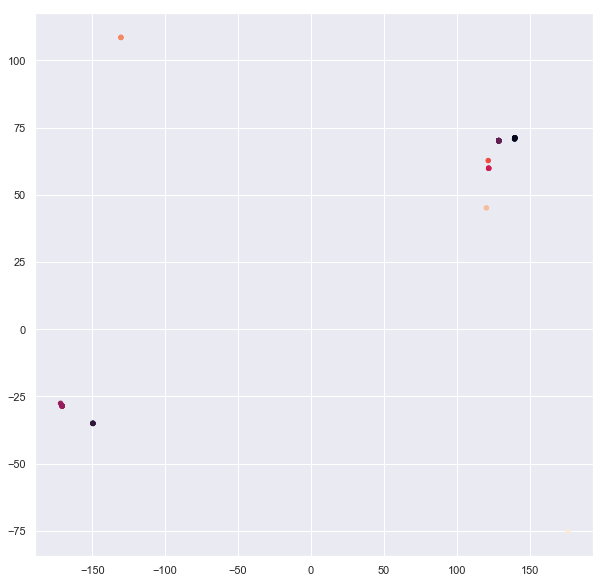

In [925]:
plt.scatter(u.Start_LON/3, u.Start_LAT/3, c=u.cluster, s=20)

In [872]:
pd.value_counts(df5['cluster_prediction'])

10    27
1      9
16     4
9      4
11     3
14     3
2      3
7      2
6      2
4      2
13     1
12     1
15     1
8      1
5      1
3      1
17     1
Name: cluster_prediction, dtype: int64

### 클러스터 간 변동량을 계산해서 비슷한 경로끼리 한 클러스터로 합치기

In [873]:
a = df5.iloc[:, 1:].groupby('cluster_prediction').mean()

In [874]:
for i in a.index:
    alist = [9999 if k == 0.0 else k for k in [round(np.mean(a.loc[j, :] - a.loc[i, :])**2, 2) for j in a.index]]
    print('{}의 최솟값은 {}이고, {}와 최솟값이다.'.format(i, min(alist), np.argmin(alist)+1))
    

1의 최솟값은 76.61이고, 3와 최솟값이다.
2의 최솟값은 18.71이고, 3와 최솟값이다.
3의 최솟값은 18.71이고, 2와 최솟값이다.
4의 최솟값은 3819.01이고, 5와 최솟값이다.
5의 최솟값은 97.97이고, 2와 최솟값이다.
6의 최솟값은 2.25이고, 8와 최솟값이다.
7의 최솟값은 0.67이고, 9와 최솟값이다.
8의 최솟값은 2.25이고, 6와 최솟값이다.
9의 최솟값은 0.67이고, 7와 최솟값이다.
10의 최솟값은 3.01이고, 11와 최솟값이다.
11의 최솟값은 3.01이고, 10와 최솟값이다.
12의 최솟값은 3.57이고, 10와 최솟값이다.
13의 최솟값은 5.35이고, 7와 최솟값이다.
14의 최솟값은 4.08이고, 16와 최솟값이다.
15의 최솟값은 1.08이고, 9와 최솟값이다.
16의 최솟값은 4.08이고, 14와 최솟값이다.
17의 최솟값은 36.56이고, 11와 최솟값이다.


In [847]:
np.mean((a1[0] - a1[1])**2)

554.8015344697916

#  

### train, test data split

In [114]:
test_date = ['201807','201808']

In [115]:
df2['ETA2'] = df2['ETA'].apply(lambda x: x[:4]+x[5:7])

In [116]:
df_test = df2.sort_values(['MMSI', 'ETA']).reset_index(drop=True).groupby('MMSI').first()['ETA2'].reset_index()
test_MMSI = df_test['MMSI'][df_test['ETA2'].isin(test_date)]

In [117]:
df2 = df2.drop(columns='ETA2')

In [118]:
train_data = df2[~df2['MMSI'].isin(test_MMSI)].reset_index(drop=True)
test_data = df2[df2['MMSI'].isin(test_MMSI)].reset_index(drop=True)

### pre-processing learning

In [119]:
def train_data_learning(train_data, lat, lon):
    df2 = port_5km(train_data, lat, lon)
    df3 = representative_value(df2)
    df4 = pd.concat([df3[['MMSI']], pd.DataFrame(df3.iloc[:, 1:])], axis=1)
    df4.columns = df3.columns
    
    df5 = auto_clustering(df4)
    
    return df5

In [129]:
train_data2 = train_data_learning(train_data, 33.754929, -118.214344)

###### test data에 근접한 baseline 찾기

In [130]:
baseline_mean_data = train_data2.groupby('cluster_prediction').mean().reset_index()
baseline_mean_data = pd.concat([baseline_mean_data.iloc[:, :17], baseline_mean_data.iloc[:, -2:]], axis=1)

In [131]:
def test_data_cluster_detect(test_data, baseline_mean_data):
    
    df1 = representative_value(test_data)
    df1_ = pd.concat([df1[['MMSI']], pd.DataFrame(df1.iloc[:, 1:])], axis=1)
    df1_.columns = df1.columns
    
    df2 = pd.concat([df1_.iloc[:, :17], df1_.iloc[:, -2:]], axis=1)
    df2['cluster_prediction'] = np.argmin([np.sum((baseline_mean_data.iloc[:,1:].loc[i,] - df2.iloc[:, 1:])**2, axis=1) for i in range(0,10)]) + 1
    test = df2
    
    return test


In [132]:
test_data4 = test_data_cluster_detect(test_data[test_data['MMSI']=='372319000_51_3'], baseline_mean_data)
train_data4 = train_data2[train_data2['cluster_prediction'].isin(test_data4['cluster_prediction'])]
# test_data4 = pd.concat([test_data4.iloc[:, 2:17], test_data4.iloc[:, -3:-1]], axis=1)
# train_data4 = pd.concat([train_data4.iloc[:, 2:17], train_data4.iloc[:, -3:-1]], axis=1)

In [ ]:
def features_make_train(data, train):
    
    c
    data.groupby('MMSI').[['MMSI', 'ETA']]min()
    
    return

In [76]:
import datetime

In [149]:
def Y_Value(data, train) : 
    data = data[data['MMSI'].isin(train['MMSI'])].reset_index(drop=True)
    data['ETA'] = data['ETA'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    lastTime = data.groupby('MMSI').last()['ETA'].reset_index()
    lastTime.columns = ['MMSI','LAST_ETA']
    data = pd.merge(data, lastTime , on = 'MMSI')
    data['y_value'] = round((data['LAST_ETA'] - data['ETA']) /np.timedelta64(1, 'h'),1)
    
    
    
    df1 = representative_value(data)
    df1 = df1[list(range(0,33,3))]
    
    
    
    
    
    return df1

In [150]:
Y_Value(df1, train_data4)

,0,3,6,9,12,15,18,21,24,27,30
0,220379000_49_3,246.5,219.1,195.0,168.8,144.9,121.0,96.1,72.1,46.5,23.1
1,352058000_14_12,285.0,247.0,219.0,189.8,160.7,134.0,108.0,80.0,52.0,24.8
2,477067900_26_11,289.1,255.1,228.2,174.2,146.1,122.2,98.2,73.1,49.1,23.1
3,477607700_40_4,289.4,252.0,224.0,196.0,167.8,141.0,113.0,83.5,54.0,27.1
4,477829700_51_9,316.9,275.0,243.9,213.0,180.0,149.9,120.0,90.0,58.8,28.9
5,477990200_46_3,294.9,256.0,226.6,196.0,168.0,138.8,111.0,83.0,55.0,26.8
6,565747000_17_3,257.0,230.2,207.0,180.8,154.7,130.0,105.0,79.0,51.9,25.6
7,636091307_15_6,295.2,260.3,229.8,203.1,174.1,144.4,117.2,88.0,61.2,30.2


In [151]:
Y_Value(df1, test_data4)

,0,3,6,9,12,15,18,21,24,27,30
0,372319000_51_3,289.0,255.0,225.6,197.1,167.0,139.0,111.0,82.9,55.1,26.7


### regression

In [154]:
a = Y_Value(df1, train_data4)

In [162]:
import xgboost as xgb

In [163]:
y_pred = xgb.XGBRegressor(booster='gblinear', eta = 10, min_child_weight =22,
                          max_depth = 8, gamma = 100 , alpha = 0.1, n_estimators=10000).fit(a.iloc[:, 1:-1], a[30]).predict(b.iloc[:, 1:-1])

In [165]:
y_pred, b[30]

(array([27.054432], dtype=float32), 0    26.7
 Name: 30, dtype: float64)

### Visualization of routes by vessel

In [170]:
import folium

In [875]:
unique_cluster = np.unique(df5['cluster_prediction'])
for iter in unique_cluster:
    df6 = df1[df1['MMSI'].isin(df5[df5['cluster_prediction']==iter]['MMSI'])].reset_index(drop=True)
    df6['LON'] = df6['LON'].apply(lambda x: x-360 if x>0 else x)
    m = folium.Map(location=[df6.loc[0,'LAT'], df6.loc[0,'LON']], zoom_start=1, tiles='Stamen Terrain')
    for i in range(df6.shape[0]):
        folium.CircleMarker(location=[df6.loc[i,'LAT'], df6.loc[i,'LON']], color = 'red', radius = 1).add_to(m)
    m.save('C:/Users/SDS/Desktop/Downloads/image(longbeach)/{}.html'.format('image'+str(iter)))

### eta eda

In [20]:
min(df1['ETA']), max(df1['ETA'])

('2016-02-11 21:44:00', '2018-08-22 22:00:00')

In [21]:
a=pd.value_counts(df1['ETA'].apply(lambda x: x[:4]+x[5:7])).sort_index()

In [22]:
import seaborn as sns

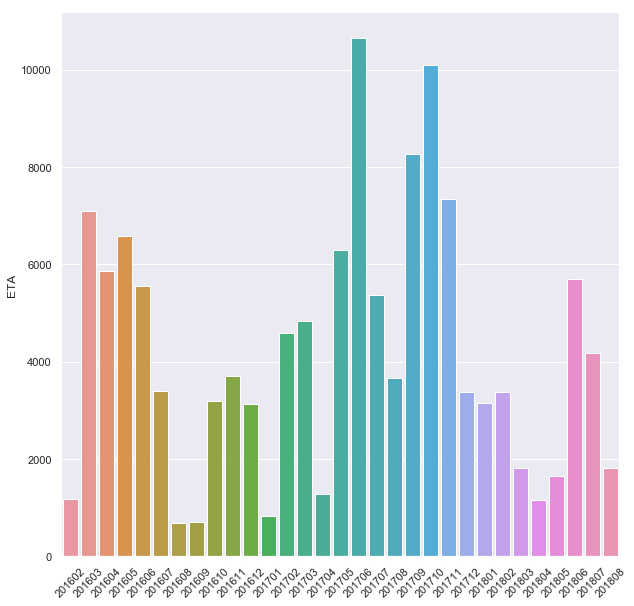

In [23]:
sns.set(rc={'figure.figsize':(10,10)})
g = sns.barplot(x=a.index, y=a)
g = g.set_xticklabels(g.get_xticklabels(),rotation=45)